In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SynchronousServer, SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=42):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.MNIST(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.MNIST(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": ((train_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": train_set.targets,
}

test_data = {
    "x": ((test_set.data - 0) / 255).reshape(-1, 28 * 28),
    "y": test_set.targets,
}

In [5]:
# Get client splits.
client_data = homogeneous_split(train_data, 10, seed=42)


In [6]:
client_data[0]["x"][0].dtype

torch.float32

## Define configuration for server and clients

In [30]:
model_config = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 0.9,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha":2.0,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 33,
}

## Set up model etc.

In [36]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI! 1 Hidden Layer

In [37]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 855.811.
Test mll: -0.098. Test acc: 0.973.
Train mll: -0.095. Train acc: 0.974.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 995.421.
Test mll: -0.092. Test acc: 0.975.
Train mll: -0.086. Train acc: 0.978.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 1105.093.
Test mll: -0.088. Test acc: 0.976.
Train mll: -0.081. Train acc: 0.980.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 1182.820.
Test mll: -0.085. Test acc: 0.977.
Train mll: -0.078. Train acc: 0.981.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1239.846.
Test mll: -0.084. Test acc: 0.976.
Train mll: -0.076. Train acc: 0.981.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1298.645.
Test mll: -0.082. Test acc: 0.977.
Train mll: -0.074. Train acc: 0.982.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 1377.547.
Test mll: -0.082. Test acc: 0.976.
Train mll: -0.073. Train acc: 0.983.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 1433.064.
Test mll: -0.080. Test acc: 0.977.
Train mll: -0.071. Train acc: 0.983.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1493.016.
Test mll: -0.080. Test acc: 0.977.
Train mll: -0.070. Train acc: 0.983.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 1573.266.
Test mll: -0.079. Test acc: 0.977.
Train mll: -0.068. Train acc: 0.984.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 1642.798.
Test mll: -0.078. Test acc: 0.978.
Train mll: -0.067. Train acc: 0.984.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 1714.439.
Test mll: -0.077. Test acc: 0.978.
Train mll: -0.066. Train acc: 0.984.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 1790.454.
Test mll: -0.077. Test acc: 0.977.
Train mll: -0.065. Train acc: 0.985.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 1847.428.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.064. Train acc: 0.985.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 1915.291.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.063. Train acc: 0.985.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 1973.318.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.063. Train acc: 0.985.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 2037.256.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.062. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 2090.541.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.062. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 2141.880.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.061. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 2188.990.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 2247.285.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.060. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 2297.951.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 2355.378.
Test mll: -0.075. Test acc: 0.979.
Train mll: -0.059. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 2428.535.
Test mll: -0.074. Test acc: 0.978.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 2482.629.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.058. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 2542.151.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 2595.811.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.057. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 2666.688.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 2741.680.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.055. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 2797.727.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 2854.481.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.056. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 2920.076.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.054. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 2982.706.
Test mll: -0.072. Test acc: 0.979.
Train mll: -0.054. Train acc: 0.988.



In [38]:
model_config2 = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config2 = {
    "damping_factor": 0.9,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha": 5.0,
}

server_config2 = {
    **client_config2,
    #100
    "max_iterations": 33,
}

In [39]:
device2 = server_config2["device"]

model2 = ClassificationBNNLocalRepam(config=model_config2)

# Initial parameters.
init_q_std_params2 = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model2.num_parameters,)).to(device2) 
    * client_config2["init_var"] ** 0.5,
}

prior_std_params2 = {
    "loc": torch.zeros(size=(model2.num_parameters,)).to(device2),
    "scale": model_config2["prior_var"] ** 0.5 
    * torch.ones(size=(model2.num_parameters,)).to(device2),
}

init_factor_nat_params2 = {
    "np1": torch.zeros(model2.num_parameters).to(device2),
    "np2": torch.zeros(model2.num_parameters).to(device2),
}

p2 = MeanFieldGaussianDistribution(
    std_params=prior_std_params2, is_trainable=False
)
init_q2 = MeanFieldGaussianDistribution(
    std_params=init_q_std_params2, is_trainable=False
)

clients2 = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params2)
    clients2.append(
        Client(
            data=data_i,
            model=model2,
            t=t_i,
            config=client_config2,
            val_data=test_data
        )
    )    
server2 = SequentialServer(model=model2, p=p2, clients=clients2, config=server_config2, init_q=init_q2, data=train_data, val_data=test_data)


In [40]:
i = 0
while not server2.should_stop():
    server2.tick()

    # Obtain performance metrics.
    metrics2 = server2.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics2["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics2["val_mll"], metrics2["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics2["train_mll"], metrics2["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 1130.336.
Test mll: -0.098. Test acc: 0.973.
Train mll: -0.084. Train acc: 0.978.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 1600.836.
Test mll: -0.087. Test acc: 0.976.
Train mll: -0.070. Train acc: 0.981.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 1695.478.
Test mll: -0.083. Test acc: 0.977.
Train mll: -0.064. Train acc: 0.983.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 1778.989.
Test mll: -0.080. Test acc: 0.977.
Train mll: -0.060. Train acc: 0.985.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1866.507.
Test mll: -0.077. Test acc: 0.977.
Train mll: -0.056. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1949.786.
Test mll: -0.075. Test acc: 0.978.
Train mll: -0.054. Train acc: 0.986.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 2024.498.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.052. Train acc: 0.987.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 2105.522.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.049. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 2183.366.
Test mll: -0.072. Test acc: 0.980.
Train mll: -0.047. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 2242.430.
Test mll: -0.072. Test acc: 0.980.
Train mll: -0.046. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 2303.889.
Test mll: -0.072. Test acc: 0.979.
Train mll: -0.046. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 2376.372.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.044. Train acc: 0.989.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 2437.902.
Test mll: -0.071. Test acc: 0.979.
Train mll: -0.043. Train acc: 0.990.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 2490.730.
Test mll: -0.071. Test acc: 0.980.
Train mll: -0.042. Train acc: 0.990.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 2562.401.
Test mll: -0.071. Test acc: 0.980.
Train mll: -0.041. Train acc: 0.990.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 2622.372.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.040. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 2676.333.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.040. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 2735.119.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.039. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 2781.209.
Test mll: -0.069. Test acc: 0.981.
Train mll: -0.039. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 2846.980.
Test mll: -0.070. Test acc: 0.981.
Train mll: -0.038. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 2920.168.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.037. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 2977.612.
Test mll: -0.070. Test acc: 0.981.
Train mll: -0.037. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 3052.846.
Test mll: -0.069. Test acc: 0.980.
Train mll: -0.036. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 3110.095.
Test mll: -0.069. Test acc: 0.981.
Train mll: -0.035. Train acc: 0.992.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 3168.650.
Test mll: -0.069. Test acc: 0.980.
Train mll: -0.035. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 3222.283.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.035. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 3293.428.
Test mll: -0.070. Test acc: 0.981.
Train mll: -0.034. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 3343.763.
Test mll: -0.069. Test acc: 0.981.
Train mll: -0.034. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 3413.571.
Test mll: -0.069. Test acc: 0.981.
Train mll: -0.033. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 3469.841.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.033. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 3536.893.
Test mll: -0.071. Test acc: 0.980.
Train mll: -0.033. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 3591.538.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.032. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 3665.248.
Test mll: -0.070. Test acc: 0.980.
Train mll: -0.032. Train acc: 0.994.



In [41]:
model_config3 = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config3 = {
    "damping_factor": 0.9,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 2500,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha": 15.0,
}

server_config3 = {
    **client_config3,
    #100
    "max_iterations": 33,
}

In [42]:
device3 = server_config3["device"]

model3 = ClassificationBNNLocalRepam(config=model_config3)

# Initial parameters.
init_q_std_params3 = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model3.num_parameters,)).to(device3) 
    * client_config3["init_var"] ** 0.5,
}

prior_std_params3 = {
    "loc": torch.zeros(size=(model3.num_parameters,)).to(device3),
    "scale": model_config3["prior_var"] ** 0.5 
    * torch.ones(size=(model3.num_parameters,)).to(device3),
}

init_factor_nat_params3 = {
    "np1": torch.zeros(model3.num_parameters).to(device3),
    "np2": torch.zeros(model3.num_parameters).to(device3),
}

p3 = MeanFieldGaussianDistribution(
    std_params=prior_std_params3, is_trainable=False
)
init_q3 = MeanFieldGaussianDistribution(
    std_params=init_q_std_params3, is_trainable=False
)

clients3 = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params3)
    clients3.append(
        Client(
            data=data_i,
            model=model3,
            t=t_i,
            config=client_config3,
            val_data=test_data
        )
)    
server3 = SequentialServer(model=model3, p=p3, clients=clients3, config=server_config3, init_q=init_q3, data=train_data, val_data=test_data)


In [43]:
i = 0
while not server3.should_stop():
    server3.tick()

    # Obtain performance metrics.
    metrics3 = server3.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics3["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics3["val_mll"], metrics3["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics3["train_mll"], metrics3["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 929.792.
Test mll: -0.085. Test acc: 0.976.
Train mll: -0.060. Train acc: 0.983.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 1107.799.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.043. Train acc: 0.988.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 1269.444.
Test mll: -0.073. Test acc: 0.980.
Train mll: -0.035. Train acc: 0.991.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 1379.809.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.030. Train acc: 0.993.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 1471.758.
Test mll: -0.073. Test acc: 0.979.
Train mll: -0.027. Train acc: 0.994.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 1568.279.
Test mll: -0.073. Test acc: 0.978.
Train mll: -0.025. Train acc: 0.995.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 1664.859.
Test mll: -0.074. Test acc: 0.979.
Train mll: -0.023. Train acc: 0.995.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 1750.207.
Test mll: -0.074. Test acc: 0.978.
Train mll: -0.021. Train acc: 0.996.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 1821.838.
Test mll: -0.075. Test acc: 0.978.
Train mll: -0.021. Train acc: 0.996.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 1889.768.
Test mll: -0.075. Test acc: 0.978.
Train mll: -0.020. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 1974.526.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.019. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 2040.290.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.018. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 2106.653.
Test mll: -0.076. Test acc: 0.979.
Train mll: -0.018. Train acc: 0.997.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 2196.937.
Test mll: -0.076. Test acc: 0.978.
Train mll: -0.017. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 2267.449.
Test mll: -0.077. Test acc: 0.978.
Train mll: -0.017. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 2335.489.
Test mll: -0.078. Test acc: 0.978.
Train mll: -0.016. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 2394.700.
Test mll: -0.078. Test acc: 0.979.
Train mll: -0.016. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 2461.703.
Test mll: -0.079. Test acc: 0.978.
Train mll: -0.016. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 2538.010.
Test mll: -0.079. Test acc: 0.978.
Train mll: -0.015. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 2599.153.
Test mll: -0.080. Test acc: 0.978.
Train mll: -0.015. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 2673.726.
Test mll: -0.080. Test acc: 0.978.
Train mll: -0.014. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 2725.550.
Test mll: -0.081. Test acc: 0.978.
Train mll: -0.014. Train acc: 0.998.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 2802.085.
Test mll: -0.082. Test acc: 0.978.
Train mll: -0.014. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 2870.104.
Test mll: -0.081. Test acc: 0.977.
Train mll: -0.014. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 2943.127.
Test mll: -0.081. Test acc: 0.978.
Train mll: -0.014. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 3006.132.
Test mll: -0.082. Test acc: 0.978.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 3077.235.
Test mll: -0.082. Test acc: 0.978.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 3140.982.
Test mll: -0.083. Test acc: 0.978.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 3213.652.
Test mll: -0.083. Test acc: 0.978.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 3279.039.
Test mll: -0.083. Test acc: 0.977.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 3339.320.
Test mll: -0.085. Test acc: 0.977.
Train mll: -0.013. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 3401.696.
Test mll: -0.083. Test acc: 0.978.
Train mll: -0.012. Train acc: 0.999.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/2500 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 3462.196.
Test mll: -0.084. Test acc: 0.977.
Train mll: -0.012. Train acc: 0.999.



In [10]:
model_config4 = {
    "input_dim": 784,
    "latent_dim": 200,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config4 = {
    "damping_factor": 0.9,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(5, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 100,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
    "divergence": "AR",
    "alpha":2.0,
}

server_config4 = {
    **client_config4,
    #100
    "max_iterations": 33,
}

In [11]:
device4 = server_config4["device"]

model4 = ClassificationBNNLocalRepam(config=model_config4)

# Initial parameters.
init_q_std_params4 = {
    "loc": torch.zeros(size=(model4.num_parameters,)).to(device4).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model4.num_parameters,)).to(device4) 
    * client_config4["init_var"] ** 0.5,
}

prior_std_params4 = {
    "loc": torch.zeros(size=(model4.num_parameters,)).to(device4),
    "scale": model_config4["prior_var"] ** 0.5 
    * torch.ones(size=(model4.num_parameters,)).to(device4),
}

init_factor_nat_params4 = {
    "np1": torch.zeros(model4.num_parameters).to(device4),
    "np2": torch.zeros(model4.num_parameters).to(device4),
}

p4 = MeanFieldGaussianDistribution(
    std_params=prior_std_params4, is_trainable=False
)
init_q4 = MeanFieldGaussianDistribution(
    std_params=init_q_std_params4, is_trainable=False
)

clients4 = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params4)
    clients4.append(
        Client(
            data=data_i,
            model=model4,
            t=t_i,
            config=client_config4,
            val_data=test_data
        )
)    
server4 = SequentialServer(model=model4, p=p4, clients=clients4, config=server_config4, init_q=init_q4, data=train_data, val_data=test_data)


In [12]:
i = 0
while not server4.should_stop():
    server4.tick()

    # Obtain performance metrics.
    metrics4 = server4.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics4["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics4["val_mll"], metrics4["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics4["train_mll"], metrics4["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 128.919.
Test mll: -0.131. Test acc: 0.961.
Train mll: -0.129. Train acc: 0.965.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

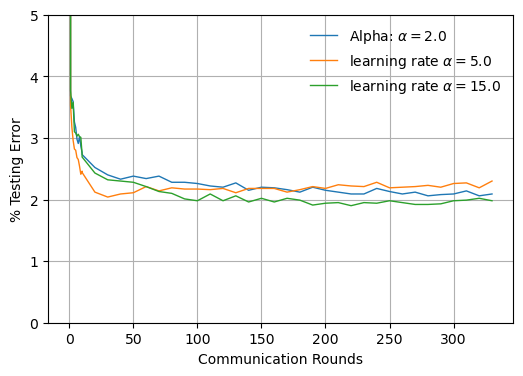

In [48]:
train_acc = []
val_acc = []
times = []
comms=[]
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
comms.append(0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
    comms.append(metrics["communications"])

train_acc2 = []
val_acc2 = []
times2 = []
train_acc2.append(100.0)
val_acc2.append(100.0)
times2.append(1.0)
comms2=[]
comms2.append(0)
for metrics in server2.log["performance_metrics"]:
    train_acc2.append(100-metrics["train_acc"]*100)
    val_acc2.append(100-metrics["val_acc"]*100)
    times2.append(metrics["time"])
    comms2.append(metrics["communications"])
train_acc3 = []
val_acc3 = []
times3 = []
comms3 = []
train_acc3.append(100.0)
val_acc3.append(100.0)
times3.append(1.0)
comms3.append(0)
for metrics in server3.log["performance_metrics"]:
    train_acc3.append(100-metrics["train_acc"]*100)
    val_acc3.append(100-metrics["val_acc"]*100)
    times3.append(metrics["time"])
    comms3.append(metrics["communications"])
    
"""train_acc4 = []
val_acc4 = []
times4 = []
comms4=[]
train_acc4.append(100.0)
val_acc4.append(100.0)
times4.append(1.0)
comms4.append(0)
for metrics in server4.log["performance_metrics"]:
    train_acc4.append(100-metrics["train_acc"]*100)
    val_acc4.append(100-metrics["val_acc"]*100)
    times4.append(metrics["time"])
    comms4.append(metrics["communications"])"""
plt.figure(figsize=(6,4))
#plt.xscale("log")
plt.ylim(0,5)
#plt.plot(comms4, val_acc4, linewidth=1., label=r"learning rate $\eta=0.9$")
plt.plot(comms, val_acc, linewidth=1., label=r"Alpha: $\alpha=2.0$")
plt.plot(comms3, val_acc3, linewidth=1., label=r"Alpha: $\alpha=5.0$")
plt.plot(comms2, val_acc2, linewidth=1., label=r"Alpha: $\alpha=15.0$")

plt.xlabel("Communication Rounds")
plt.ylabel("% Testing Error")
plt.legend(loc="upper right", frameon=False)
plt.grid(visible=True)

#plt.savefig('Synchronous_PGVI_MNIST.pgf', pad_inches=0)
plt.show()